In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing, cross_validation, metrics #model_selection, 
#from CrossValidation import CVScore
from sklearn.grid_search import GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.preprocessing import Imputer

import xgboost as xgb
import datetime
from sklearn.metrics import mean_squared_error as mse, make_scorer
from sklearn.cross_validation import train_test_split
#now = datetime.datetime.now()


pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

#id_test = test.id
#multiplier = 0.969

def RMSLE_(y_val, y_val_pred):
    return np.sqrt(np.mean((np.log(y_val+1)-np.log(y_val_pred+1))**2))
RMSLE = make_scorer(RMSLE_, greater_is_better=False) 

def RMSE_(y_val, y_val_pred):
    return np.sqrt(np.mean((y_val-y_val_pred)**2))
RMSE = make_scorer(RMSE_, greater_is_better=False)

from time import time

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
X_train = pd.read_csv('./input/train_further_additional_feature_filtered.csv',index_col=0)
y_train = pd.read_csv('./input/y_train_further_additional_feature_filtered.csv',index_col=0)['price_doc']
X_test = pd.read_csv('./input/test_further_additional_feature_filtered.csv',index_col=0)
macro = pd.read_csv('./input/macro.csv', parse_dates=['timestamp'])
id_test = pd.read_csv('./input/test.csv').id

In [3]:
imp = Imputer(missing_values=np.nan, strategy='median')
imp.fit(pd.concat([X_train,X_test]))
X_train = pd.DataFrame(imp.transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(imp.transform(X_test),columns=X_test.columns)

In [4]:
imp = Imputer(missing_values=np.infty, strategy='median')
imp.fit(pd.concat([X_train,X_test]))
X_train = pd.DataFrame(imp.transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(imp.transform(X_test),columns=X_test.columns)

In [5]:
target = "price_doc"
predictors = X_train.columns
X_train[target]=y_train

In [6]:
def modelfitGBM(alg, dtrain, predictors, target=target, CVMetrics=RMSLE, outputMetrics=RMSLE_,
                performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], 
                                                    dtrain[ target], cv=cv_folds, scoring=CVMetrics)
    
    #Print model report:
    print "\nModel Report"
    #print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions)
    print "RMSE (Train): %f" % outputMetrics(dtrain[target], dtrain_predictions)
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)[:50]
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.figure(figsize=(20,10))


Model Report
RMSE (Train): 0.000551
CV Score : Mean - -0.4717017 | Std - 0.07754243 | Min - -0.6908601 | Max - -0.4058566


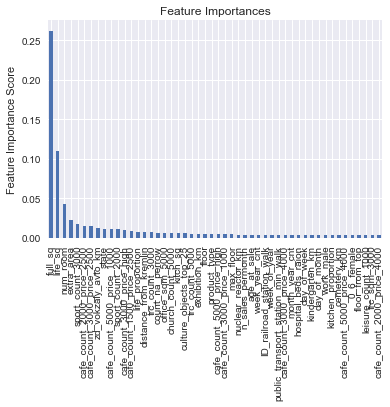

In [33]:
gbm0 = ExtraTreesRegressor(random_state=5)
modelfitGBM(gbm0, X_train, predictors, target, CVMetrics=RMSLE, outputMetrics=RMSLE_, cv_folds=10)

In [22]:
param_test = {'random_state':[5,10,48,123]}
gsearch = GridSearchCV(estimator = ExtraTreesRegressor(), 
param_grid = param_test, scoring=RMSE, n_jobs=-1, cv=10)#iid=False, 
gsearch.fit(X_train[predictors],np.log(X_train[target]+1))
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: -0.49192, std: 0.06945, params: {'random_state': 5},
  mean: -0.49100, std: 0.06844, params: {'random_state': 10},
  mean: -0.49340, std: 0.06912, params: {'random_state': 48},
  mean: -0.49091, std: 0.06813, params: {'random_state': 123}],
 {'random_state': 123},
 -0.4909086311780212)

In [9]:
param_test = {'n_estimators':range(100,1100,100)}
gsearch = GridSearchCV(estimator = ExtraTreesRegressor(min_samples_split=500,max_depth=5,
                        min_samples_leaf=50,max_features='sqrt',random_state=10), 
param_grid = param_test, scoring=RMSE, n_jobs=-1, cv=10)#iid=False, 
gsearch.fit(X_train[predictors],np.log(X_train[target]+1))
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: -0.54471, std: 0.06061, params: {'n_estimators': 100},
  mean: -0.54595, std: 0.06062, params: {'n_estimators': 200},
  mean: -0.54567, std: 0.06076, params: {'n_estimators': 300},
  mean: -0.54523, std: 0.06080, params: {'n_estimators': 400},
  mean: -0.54543, std: 0.06073, params: {'n_estimators': 500},
  mean: -0.54565, std: 0.06069, params: {'n_estimators': 600},
  mean: -0.54567, std: 0.06076, params: {'n_estimators': 700},
  mean: -0.54545, std: 0.06082, params: {'n_estimators': 800},
  mean: -0.54521, std: 0.06083, params: {'n_estimators': 900},
  mean: -0.54523, std: 0.06075, params: {'n_estimators': 1000}],
 {'n_estimators': 100},
 -0.5447121015060877)

In [11]:
param_test = {'n_estimators':range(50,200,50)}
gsearch = GridSearchCV(estimator = ExtraTreesRegressor(min_samples_split=500,
                        min_samples_leaf=50,max_depth=5,max_features='sqrt',random_state=10), 
param_grid = param_test, scoring=RMSE, n_jobs=-1, cv=10)#iid=False, 
gsearch.fit(X_train[predictors],np.log1p(X_train[target]))
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: -0.54535, std: 0.06062, params: {'n_estimators': 50},
  mean: -0.54471, std: 0.06061, params: {'n_estimators': 100},
  mean: -0.54560, std: 0.06052, params: {'n_estimators': 150}],
 {'n_estimators': 100},
 -0.5447121015060877)

In [13]:
param_test = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch = GridSearchCV(estimator = ExtraTreesRegressor(n_estimators=100,
                        min_samples_leaf=50,max_features='sqrt', random_state=10), 
param_grid = param_test, scoring=RMSE, n_jobs=-1,cv=5)#iid=False, 
gsearch.fit(X_train[predictors],np.log(X_train[target]+1))
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: -0.54660, std: 0.04192, params: {'min_samples_split': 200, 'max_depth': 5},
  mean: -0.54786, std: 0.04187, params: {'min_samples_split': 400, 'max_depth': 5},
  mean: -0.54857, std: 0.04168, params: {'min_samples_split': 600, 'max_depth': 5},
  mean: -0.55056, std: 0.04189, params: {'min_samples_split': 800, 'max_depth': 5},
  mean: -0.55036, std: 0.04196, params: {'min_samples_split': 1000, 'max_depth': 5},
  mean: -0.53330, std: 0.04499, params: {'min_samples_split': 200, 'max_depth': 7},
  mean: -0.53504, std: 0.04385, params: {'min_samples_split': 400, 'max_depth': 7},
  mean: -0.53640, std: 0.04367, params: {'min_samples_split': 600, 'max_depth': 7},
  mean: -0.53840, std: 0.04367, params: {'min_samples_split': 800, 'max_depth': 7},
  mean: -0.53997, std: 0.04318, params: {'min_samples_split': 1000, 'max_depth': 7},
  mean: -0.52435, std: 0.04571, params: {'min_samples_split': 200, 'max_depth': 9},
  mean: -0.52687, std: 0.04449, params: {'min_samples_split': 400, 'max_de

In [14]:
param_test = {'max_depth':range(15,25,2), 'min_samples_split':range(100,400,100)}
gsearch = GridSearchCV(estimator = ExtraTreesRegressor(n_estimators=100,
                        min_samples_leaf=50,max_features='sqrt', random_state=10), 
param_grid = param_test, scoring=RMSE, n_jobs=-1,cv=5)#iid=False, 
gsearch.fit(X_train[predictors],np.log(X_train[target]+1))
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: -0.51216, std: 0.04557, params: {'min_samples_split': 100, 'max_depth': 15},
  mean: -0.51398, std: 0.04468, params: {'min_samples_split': 200, 'max_depth': 15},
  mean: -0.51704, std: 0.04467, params: {'min_samples_split': 300, 'max_depth': 15},
  mean: -0.51128, std: 0.04524, params: {'min_samples_split': 100, 'max_depth': 17},
  mean: -0.51336, std: 0.04494, params: {'min_samples_split': 200, 'max_depth': 17},
  mean: -0.51690, std: 0.04472, params: {'min_samples_split': 300, 'max_depth': 17},
  mean: -0.51083, std: 0.04508, params: {'min_samples_split': 100, 'max_depth': 19},
  mean: -0.51337, std: 0.04478, params: {'min_samples_split': 200, 'max_depth': 19},
  mean: -0.51631, std: 0.04497, params: {'min_samples_split': 300, 'max_depth': 19},
  mean: -0.51043, std: 0.04559, params: {'min_samples_split': 100, 'max_depth': 21},
  mean: -0.51321, std: 0.04506, params: {'min_samples_split': 200, 'max_depth': 21},
  mean: -0.51603, std: 0.04456, params: {'min_samples_split': 300

In [16]:
param_test = {'min_samples_split':range(50,200,50), 'min_samples_leaf':range(70,100,10)}
gsearch = GridSearchCV(estimator = ExtraTreesRegressor(max_depth=21, n_estimators=100,
                        max_features='sqrt',random_state=10), 
param_grid = param_test, scoring=RMSE, n_jobs=-1,cv=10)#iid=False, 
gsearch.fit(X_train[predictors],np.log(X_train[target]+1))
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: -0.50877, std: 0.06313, params: {'min_samples_split': 50, 'min_samples_leaf': 70},
  mean: -0.50877, std: 0.06313, params: {'min_samples_split': 100, 'min_samples_leaf': 70},
  mean: -0.50874, std: 0.06282, params: {'min_samples_split': 150, 'min_samples_leaf': 70},
  mean: -0.51167, std: 0.06257, params: {'min_samples_split': 50, 'min_samples_leaf': 80},
  mean: -0.51167, std: 0.06257, params: {'min_samples_split': 100, 'min_samples_leaf': 80},
  mean: -0.51167, std: 0.06257, params: {'min_samples_split': 150, 'min_samples_leaf': 80},
  mean: -0.51459, std: 0.06305, params: {'min_samples_split': 50, 'min_samples_leaf': 90},
  mean: -0.51459, std: 0.06305, params: {'min_samples_split': 100, 'min_samples_leaf': 90},
  mean: -0.51459, std: 0.06305, params: {'min_samples_split': 150, 'min_samples_leaf': 90}],
 {'min_samples_leaf': 70, 'min_samples_split': 150},
 -0.5087445753215601)


Model Report
RMSE (Train): 0.514775
CV Score : Mean - -0.5227264 | Std - 0.07921019 | Min - -0.7529788 | Max - -0.4550779


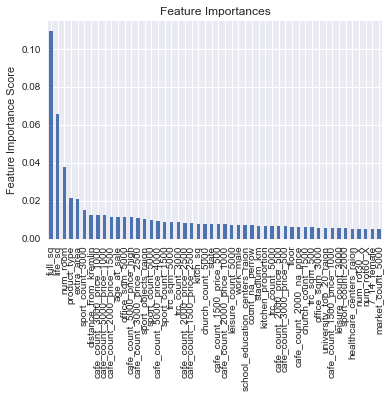

In [20]:
EXTreg=ExtraTreesRegressor(n_estimators=100,min_samples_leaf=70,min_samples_split=150, 
                           max_features="sqrt",max_depth=21,random_state=10)
modelfitGBM(EXTreg, X_train, predictors, target, CVMetrics=RMSLE, outputMetrics=RMSLE_, cv_folds=10)

In [21]:
param_test = {'max_features':1/10.0*np.arange(1,10,1)}
gsearch = GridSearchCV(estimator = ExtraTreesRegressor(max_depth=21, n_estimators=100,min_samples_leaf=70,
                        min_samples_split=150, max_features='sqrt',random_state=10), 
param_grid = param_test, scoring=RMSE, n_jobs=-1,cv=10)#iid=False, 
gsearch.fit(X_train[predictors],np.log(X_train[target]+1))
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: -0.50005, std: 0.06343, params: {'max_features': 0.10000000000000001},
  mean: -0.48104, std: 0.06400, params: {'max_features': 0.20000000000000001},
  mean: -0.47309, std: 0.06423, params: {'max_features': 0.30000000000000004},
  mean: -0.46897, std: 0.06446, params: {'max_features': 0.40000000000000002},
  mean: -0.46658, std: 0.06505, params: {'max_features': 0.5},
  mean: -0.46532, std: 0.06531, params: {'max_features': 0.60000000000000009},
  mean: -0.46434, std: 0.06559, params: {'max_features': 0.70000000000000007},
  mean: -0.46364, std: 0.06619, params: {'max_features': 0.80000000000000004},
  mean: -0.46306, std: 0.06651, params: {'max_features': 0.90000000000000002}],
 {'max_features': 0.90000000000000002},
 -0.46305784349430695)

In [23]:
param_test = {'max_features':1/10.0*np.arange(9,11,1)}
gsearch = GridSearchCV(estimator = ExtraTreesRegressor(max_depth=21, n_estimators=100,min_samples_leaf=70,
                        min_samples_split=150, max_features='sqrt',random_state=10), 
param_grid = param_test, scoring=RMSE, n_jobs=-1,cv=10)#iid=False, 
gsearch.fit(X_train[predictors],np.log(X_train[target]+1))
gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

([mean: -0.46306, std: 0.06651, params: {'max_features': 0.90000000000000002},
  mean: -0.46290, std: 0.06631, params: {'max_features': 1.0}],
 {'max_features': 1.0},
 -0.4628994268451725)


Model Report
RMSE (Train): 0.460380
CV Score : Mean - -0.4724763 | Std - 0.07623496 | Min - -0.6903008 | Max - -0.4111295


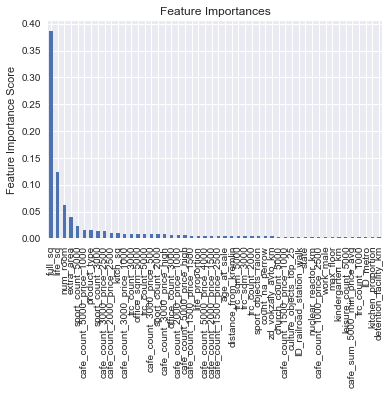

In [30]:
EXTreg=ExtraTreesRegressor(n_estimators=100,min_samples_leaf=70,min_samples_split=150, 
                           max_features=.9,max_depth=21,random_state=10)
modelfitGBM(EXTreg, X_train, predictors, target, CVMetrics=RMSLE, outputMetrics=RMSLE_, cv_folds=10)

In [31]:
EXTreg=ExtraTreesRegressor(n_estimators=100,min_samples_leaf=70,min_samples_split=150, 
                           max_features=.9,max_depth=21,random_state=10)
EXTreg.fit(X_train[predictors], np.log(y_train+1))
y_predict = EXTreg.predict(X_test)
y_predict = np.exp(y_predict)-1
#y_predict = np.round(y_predict)#np.round(y_predict * 0.99)
#output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})

In [34]:
EXTreg=ExtraTreesRegressor(random_state=123)
EXTreg.fit(X_train[predictors], np.log(y_train+1))
y_predict = EXTreg.predict(X_test)
y_predict = np.exp(y_predict)-1
#y_predict = np.round(y_predict)#np.round(y_predict * 0.99)
#output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})

In [35]:
output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})
output.to_csv('Jun19_3_ETRTune_rnd123.csv', index=False)
#output.to_csv('Jun19_2_ETRTune_nEst100_minSmpSplt150_maxFtPt9_maxDpt21_minSmLf70_rnd10.csv', index=False)